### auxiliary structures

In [1]:
def distance(p1, p2):
    d = 0
    for i in range(len(p1)):
        d += pow(p1[i] - p2[i], 2)
    return d

def most_frequent(List):
    return max(set(List), key = List.count)

def sort_list_by_index(l, index):
    return sorted(l, key=lambda x: x[0][index])

class Node:
    def __init__(self, data, label, lvl):
        self.data = data
        self.label = label
        self.lvl = lvl
        self.left_side = []
        self.right_side = []

class KDTree:
    def fit(self, data, labels):
        self.dimensions = len(data[0])
        lvl = 0

        dataLabelTuple = []
        for i in range(len(data)):
            dataLabelTuple.append((data[i], labels[i]))

        self.root = self.__create_next_lvl(dataLabelTuple, 0)

    def get_nearest_neighbor(self, search_point):
        return self.__nearest_neighbor(self.root, search_point, self.root)

    def __create_next_lvl(self, dataLabelTuple, lvl):
        if len(dataLabelTuple) == 0: return None

        # Decides which feature should be used at the current level
        sortedData = sort_list_by_index(dataLabelTuple, lvl % self.dimensions)

        lvlRootIndex = len(sortedData) // 2
        lvlRootNode = Node(sortedData[lvlRootIndex][0], sortedData[lvlRootIndex][1], lvl)
        
        nextLevel = lvl + 1

        lvlRootNode.left_side = self.__create_next_lvl(sortedData[:lvlRootIndex], nextLevel)
        lvlRootNode.right_side = self.__create_next_lvl(sortedData[lvlRootIndex + 1:], nextLevel)

        return lvlRootNode

    def __nearest_neighbor(self, n, search_point, c_neighbor):
        if n == None: return c_neighbor

        if distance(n.data, search_point) < distance(search_point, c_neighbor.data): c_neighbor = n

        lvlFeatureIndex = n.lvl % self.dimensions

        if n.data[lvlFeatureIndex] > search_point[lvlFeatureIndex]:
            good_side = n.left_side
            bad_side = n.right_side
        else:
            good_side = n.right_side
            bad_side = n.left_side
        
        c_neighbor = self.__nearest_neighbor(good_side, search_point, c_neighbor)

        return c_neighbor
        

### KNN

In [2]:
class KNN:
    def __init__(self, kd_tree = False):
        self.using_kdtree = kd_tree

    def fit(self, X_train, y_train):
        if self.using_kdtree:
            self.kd_tree = KDTree()
            self.kd_tree.fit(X_train, y_train)
        else:
            self.X_train = X_train
            self.y_train = y_train

    def predict(self, X_predict, k = 1):
        predictions = []

        for x_pred in X_predict:
            if self.using_kdtree:
                closest_neigh = self.kd_tree.get_nearest_neighbor(x_pred)
                predictions.append(closest_neigh.label)
            else:
                closest_points = self.__get_closest_points(x_pred, k)
                prediction = self.__get_prediction(closest_points)
                predictions.append(prediction)

        return predictions


    # Brute force
    def __get_closest_points(self, x_pred, k):
        closest_points = []

        for i in range(len(self.X_train)):
            x_train = self.X_train[i]
            dist = distance(x_pred, x_train)
            closest_points = self.__add_point_to_closest_points(i, dist, k, closest_points)
        
        return closest_points


    def __add_point_to_closest_points(self, point_index, dist, k, closest_points):
        for i in range(k):
            if i == len(closest_points):
                closest_points.append((point_index, dist))
                break
            else:
                if dist < closest_points[i][1]:
                    closest_points.insert(i, (point_index, dist))
                    break
        return closest_points
            
    def __get_prediction(self, closest_points):
        classes = []

        for point in closest_points:
            classes.append(self.y_train[point[0]][0])
        
        return most_frequent(classes)

### Pre-processing

In [3]:
from cProfile import label
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from warnings import filterwarnings
filterwarnings('ignore')

df = pd.read_csv("penguins.csv")
df = df[['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Species']]
df = df.dropna()

X = df[['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)']]
y = df[['Species']]

scaler = StandardScaler().fit(X.values)
features = scaler.transform(X.values)

X[X.columns[:]] = features

### KNN Brute force

                                           precision    recall  f1-score   support

      Adelie Penguin (Pygoscelis adeliae)       0.89      1.00      0.94        40
Chinstrap penguin (Pygoscelis antarctica)       1.00      0.79      0.88        24
        Gentoo penguin (Pygoscelis papua)       1.00      1.00      1.00        39

                                 accuracy                           0.95       103
                                macro avg       0.96      0.93      0.94       103
                             weighted avg       0.96      0.95      0.95       103



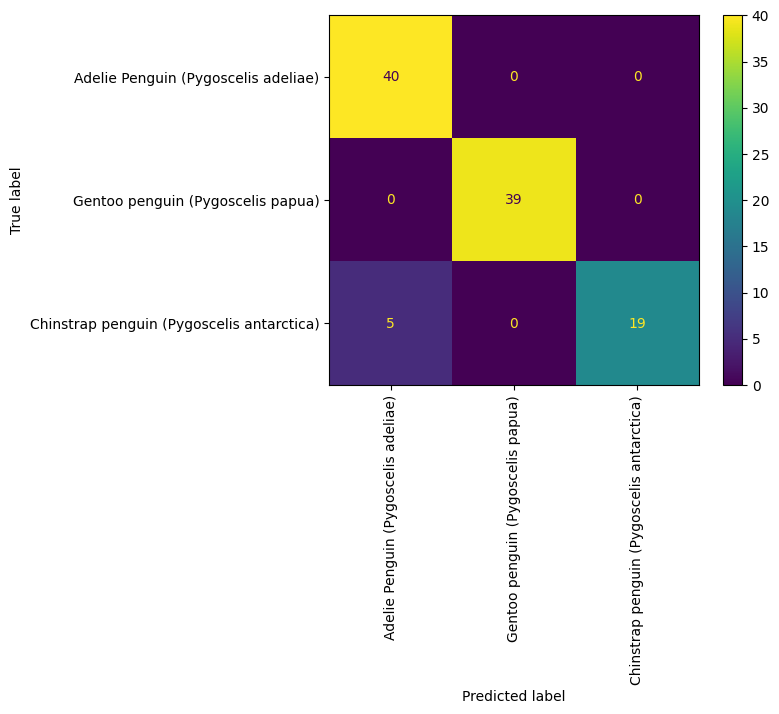

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

x_train_list = X_train.values.tolist()
y_train_list = y_train.values.tolist()
X_test_list = X_test.values.tolist()

knn = KNN()

knn.fit(x_train_list, y_train_list)
y_pred = knn.predict(X_test_list, k=5)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=df['Species'].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df['Species'].unique())
disp.plot(xticks_rotation='vertical')
plt.show()

### KNN KDTree

                                           precision    recall  f1-score   support

      Adelie Penguin (Pygoscelis adeliae)       1.00      0.96      0.98        55
Chinstrap penguin (Pygoscelis antarctica)       0.89      1.00      0.94        17
        Gentoo penguin (Pygoscelis papua)       1.00      1.00      1.00        31

                                 accuracy                           0.98       103
                                macro avg       0.96      0.99      0.98       103
                             weighted avg       0.98      0.98      0.98       103



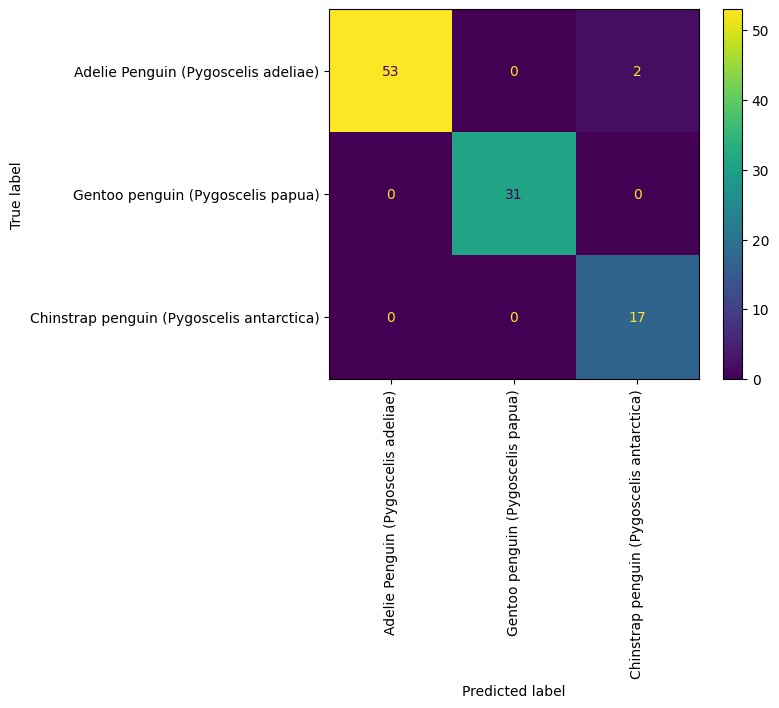

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

x_train_list = X_train.values.tolist()
y_train_list = y_train.values.tolist()
X_test_list = X_test.values.tolist()

knn = KNN(kd_tree=True)

knn.fit(x_train_list, y_train_list)
y_pred = knn.predict(X_test_list)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=df['Species'].unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df['Species'].unique())
disp.plot(xticks_rotation='vertical')
plt.show()